In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
import tensorflow as tf
import os
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
!mkdir htr_v1
%cd htr_v1/
!pwd

/content/htr_v1
/content/htr_v1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir dataset
!mkdir -p dataset/img
!mkdir -p dataset/gt
%cd dataset/
!cp "/content/drive/MyDrive/dataset/IAM_Words.zip" "/content/htr_v1/dataset/"
# !wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip IAM_Words.zip
!mv IAM_Words/words.txt gt/
!mv IAM_Words/words.tgz img/
!rmdir IAM_Words
%cd img
!tar -xf words.tgz
!rm words.tgz
%cd /content/htr_v1

/content/htr_v1/dataset
Archive:  IAM_Words.zip
   creating: IAM_Words/
  inflating: IAM_Words/words.tgz     
  inflating: IAM_Words/words.txt     
/content/htr_v1/dataset/img
/content/htr_v1


In [ ]:
first_line = open(f"/content/htr_v1/dataset/gt/words.txt", "r").readlines()
words=first_line[18:]

In [ ]:
words_list = []
#error_list= []
#Lines_with_hash_list=[]
# ground path is: "/content/htr_v1/dataset/gt/words.txt"
# = open(f"/content/htr_v1/dataset/gt/words.txt", "r").readlines()
for line in words:
    #if line[0]=='#':
        #Lines_with_hash_list.append(line)
        #continue
    if line.split(" ")[1]=="ok": # We don't need to deal with errored entries.
        words_list.append(line)
    #if line.split(" ")[1] == "err":
        #error_list.append(line)

#print("Total Number of Words in Dataset: ", len(words_list))

In [ ]:
words_list = []
#error_list= []
#Lines_with_hash_list=[]
# ground path is: "/content/htr_v1/dataset/gt/words.txt"
# = open(f"/content/htr_v1/dataset/gt/words.txt", "r").readlines()
for line in words:
    #if line[0]=='#':
        #Lines_with_hash_list.append(line)
        #continue
    if line.split(" ")[1]=="ok": # We don't need to deal with errored entries.
        words_list.append(line)
    #if line.split(" ")[1] == "err":
        #error_list.append(line)

#print("Total Number of Words in Dataset: ", len(words_list))

In [ ]:
len(words)

115320

In [ ]:
#words_list
print(len(words_list))

96456


In [ ]:
#Before we split the dataset, the data inside the dataset will be shuffled randomly
# I am working only with the valid data list named "word_list" and ofcourse with label menas ground truth.
np.random.shuffle(words_list)

split_words = int(0.8 * len(words_list))
train_samples = words_list[:split_words]
test_samples = words_list[split_words:]

val_split_words= int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_words]
test_samples = test_samples[val_split_words:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)
print(f"Total Training Data: {len(train_samples)}")
print(f"Total Validation Data: {len(validation_samples)}")
print(f"Total Test Data: {len(test_samples)}")
#a= len(words_list)
#b=len(train_samples) + len(validation_samples) + len(test_samples)
print(f"Sum of train test and validation: {len(train_samples) + len(validation_samples) + len(test_samples)}")
print(f"Total word list: {len(words_list)}")

Total Training Data: 77164
Total Validation Data: 9646
Total Test Data: 9646
Sum of train test and validation: 96456
Total word list: 96456


In [ ]:
base_image_path = "/content/htr_v1/dataset/img"
#/content/htr_v1/dataset/img/a01/a01-000u/a01-000u-00-00.png
def get_image_and_gt(samples):
    #print(samples)
    paths = []
    fixed_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path =  os.path.join(base_image_path, partI,
            partI + "-" + partII,
            image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            fixed_samples.append(file_line.split("\n")[0])

    return paths, fixed_samples

train_img_paths, train_labels = get_image_and_gt(train_samples)
validation_img_paths, validation_labels = get_image_and_gt(validation_samples)
test_img_paths, test_labels = get_image_and_gt(test_samples)

In [ ]:
# Finding maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0
for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)
#Checking to see the cleaned labels, extra commas and dots have been removed
print("Some Cleaned Lables ", train_labels_cleaned[:5])

Some Cleaned Lables  ['sure', 'he', 'during', 'of', 'booty']


In [ ]:
def cleaning_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = cleaning_labels(validation_labels)
test_labels_cleaned = cleaning_labels(test_labels)

In [ ]:
#We need to seperate the characters in each words from the output of the model, we have to make a vocabulary
#for the words that is predicted
AUTOTUNE = tf.data.AUTOTUNE
# Mapping characters to integers,
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
# Mapping integers back to original characters.
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image  = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Checking tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
                  [pad_height_top, pad_height_bottom],
                  [pad_width_left, pad_width_right],
                  [0, 0]
                ]
        )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def process_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    return image


def make_word(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_gt(image_path, label):
    image = process_image(image_path)
    label = make_word(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_gt, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [ ]:
train_dataset = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_dataset = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_dataset= prepare_dataset(test_img_paths, test_labels_cleaned)

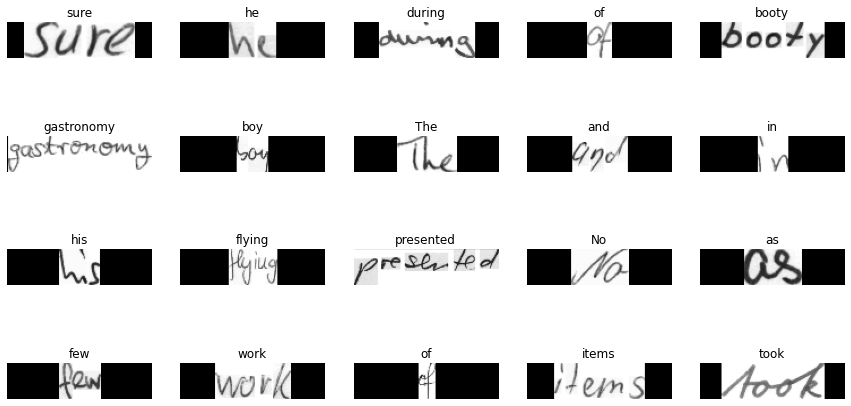

In [ ]:
for data in train_dataset.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 5, figsize=(15, 8))

    for i in range(20):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")
        ax[i // 5, i % 5].imshow(img, cmap="gray")
        ax[i // 5, i % 5].set_title(label)
        ax[i // 5, i % 5].axis("off")

plt.show()

In [ ]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [ ]:
def build_model():
    # Inputs to the model
    input_img =  keras.Input(shape=(image_width, image_height, 1), name="image")
    labels =  keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(6, (5, 5), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1",)(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
    # Second conv block.
    x = keras.layers.Conv2D(16, (5, 5), activation="relu",kernel_initializer="he_normal",padding="same", name="Conv2",)(x)
    x =  keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # # 3th conv block.
    x = keras.layers.Conv2D(200, (5, 5), activation="relu",kernel_initializer="he_normal",padding="same", name="Conv3",)(x)
    x = keras.layers.Conv2D(200, (5, 5), activation="relu",kernel_initializer="he_normal",padding="same", name="Conv4",)(x)
    #x = keras.layers.Conv2D(200, (5, 5), activation="relu",kernel_initializer="he_normal",padding="same", name="Conv5",)(x)
    #x= keras.layers.Dense(120, activation="relu", name="dense1")(x)
    #x = keras.layers.Flatten (name = 'flatten') (x)
    #We used to layers of max pooling with size and strides of 2, the feature maps from this will result in 4x smaller feature maps
    #The total number of filters in last layer is set to 64 dye to which we must reshape accordingly before passing output to RNN part of the architecture
    new_shape = ((image_width // 4), (image_height // 4) * 200)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(120, activation="relu", name="dense1")(x)
    x = keras.layers.Dense(84, activation="relu", name="dense2")(x)
    x = keras.layers.Dropout(0.2)(x)

    # Recurrent NN Layers.
    x =  keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x =  keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    # Output layer (the tokenizer is char-level)
    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x =  keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense3")(x)
    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)
    # Define the model.
    model =  keras.models.Model(inputs=[input_img, labels], outputs=output, name="handwriting_recognizer_lenet_5")
    # Optimizer used is
    opt = tf.keras.optimizers.Adam()
    metric = keras.metrics.Accuracy()
    #Put the model together and  Compile the model and return the model.
    model.compile(optimizer=opt, metrics = metric)
    return model

In [ ]:
#Store the model in a variable called model
model = build_model()
model.summary()

Model: "handwriting_recognizer_lenet_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 6)   156         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 6)    0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 16)   2416        ['po

In [ ]:
iterations = 150 # To get good results this should be at least 50.
# Train the model
model = build_model()
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=iterations,
)

Epoch 1/150
1206/1206 [==============================] - 82s 49ms/step - loss: 13.1883 - accuracy: 0.0000e+00 - val_loss: 10.7404 - val_accuracy: 0.0000e+00
Epoch 2/150
1206/1206 [==============================] - 49s 41ms/step - loss: 9.4276 - accuracy: 0.0000e+00 - val_loss: 8.1639 - val_accuracy: 0.0000e+00
Epoch 3/150
1206/1206 [==============================] - 49s 41ms/step - loss: 6.8146 - accuracy: 0.0000e+00 - val_loss: 5.2978 - val_accuracy: 0.0000e+00
Epoch 4/150
1206/1206 [==============================] - 49s 41ms/step - loss: 4.7768 - accuracy: 0.0000e+00 - val_loss: 4.0641 - val_accuracy: 0.0000e+00
Epoch 5/150
1206/1206 [==============================] - 50s 42ms/step - loss: 3.7836 - accuracy: 0.0000e+00 - val_loss: 3.5169 - val_accuracy: 0.0000e+00
Epoch 6/150
1206/1206 [==============================] - 50s 41ms/step - loss: 3.2192 - accuracy: 0.0000e+00 - val_loss: 3.2735 - val_accuracy: 0.0000e+00
Epoch 7/150
1206/1206 [==============================] - 50s 41ms/st

In [ ]:
# To make prediction using the model we created, must extract the model's last layer and then use that layer to make prediction on it.
prediction_model = keras.models.Model( model.get_layer(name="image").input, model.get_layer(name="dense3").output)
print("Prediction Model Summary: " ,prediction_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 128, 32, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 128, 32, 6)        156       
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 16, 6)         0         
                                                                 
 Conv2 (Conv2D)              (None, 64, 16, 16)        2416      
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 8, 16)         0         
                                                                 
 Conv3 (Conv2D)              (None, 32, 8, 200)        80200     
                                                                 
 Conv4 (Conv2D)              (None, 32, 8, 200)        100020

2/2 [==============================] - 2s 8ms/step


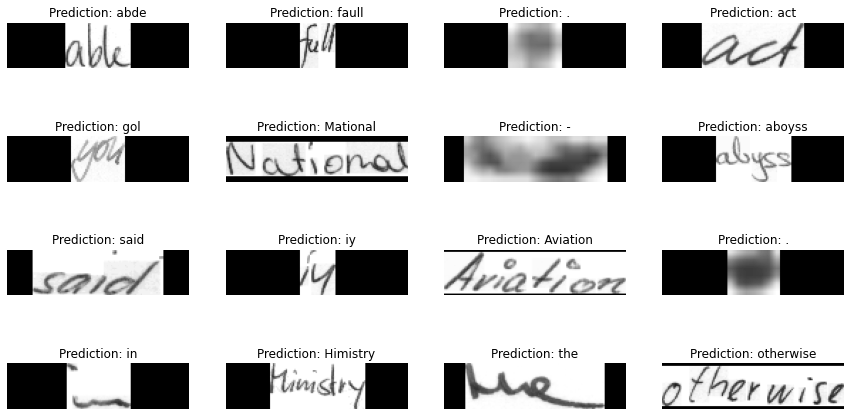

In [ ]:
# The model outputs the results in a raw form, we have to use the vocabulary created above to decode the output into human readable format.
def decode_model_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_dataset.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_model_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

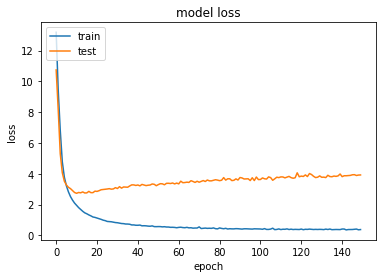

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

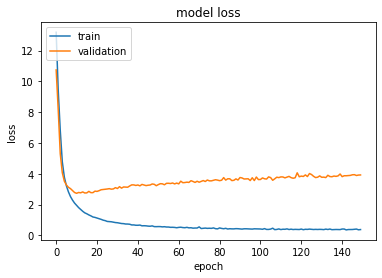

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

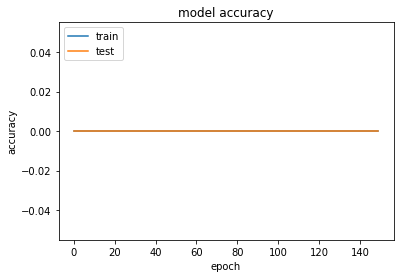

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
prediction_model.save('/content/drive/MyDrive/HTR_CNN1_LENET5')

In [ ]:
prediction_saved_model = keras.models.load_model('/content/drive/MyDrive/HTR_CNN1_LENET5')

In [ ]:
# The model outputs the results in a raw form, we have to use the vocabulary created above to decode the output into human readable format.
def decode_model_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_dataset.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_saved_model.predict(batch_images)
    pred_texts = decode_model_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()